***
# <font color=red>Building and Explaining a Regressor using AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

Regression Demo Notebook.

Copyright © 2023, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook

In this notebook we will build a regressor using the Oracle AutoMLx tool for the public California Housing dataset to predict the value of house prices.
We explore the various options provided by the Oracle AutoMLx tool, allowing the user to control the AutoMLx training process. We finally evaluate the different models trained by AutoMLx. Depending on the dataset size and the machine running it, it can take about tens of minutes. The dataset is sampled down for a snappier demo, with the option to run it with the full dataset. We finally provide an overview of the possibilities that Oracle AutoMLx provides for explaining the predictions of the tuned model.

---
## Prerequisites:

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry experience
---

## Business Use:

Data analytics and modeling problems using Machine Learning (ML) are becoming popular and often rely on data science expertise to build accurate ML models. Such modeling tasks primarily involve the following steps:
- Preprocess dataset (clean, impute, engineer features, normalize).
- Pick an appropriate model for the given dataset and prediction task at hand.
- Tune the chosen model’s hyperparameters for the given dataset.

All of these steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoML can quickly jump-start the datascience process with an accurately-tuned model and appropriate features for a given prediction task.

## Table of Contents

- <a href='#setup'> Setup</a>
- <a href='#load-data'> Load California housing dataset</a>
- <a href='#AutoML'> AutoML</a>
  - <a href='#Engine'> Setting the execution engine</a>
  - <a href='#provider'> Create an Instance of AutoMLx</a>
  - <a href='#default'> Train a Model using AutoMLx</a>
  - <a href='#analyze'> Analyze the AutoMLx optimization process </a>
      - <a href='#algorithm-selection'> Algorithm Selection</a>
      - <a href='#adaptive-sampling'> Adaptive Sampling</a>
      - <a href='#feature-selection'> Feature Selection</a>
      - <a href='#hyperparameter-tuning'> Hyperparameter Tuning</a>
  - <a href='#modellist'> Advanced AutoMLx Configuration </a>
      - <a href='#custom-validation'> Use a custom validation set</a>
- <a href='#MLX'> Machine Learning Explainability (MLX)</a>
  - <a href='#MLX-initializing'> Initialize an MLExplainer</a>
  - <a href='#MLX-global'> Model Explanations (Global Feature Importance)</a>
  - <a href='#MLX-dependency'> Feature Dependence Explanations (PDP + ICE)</a>
  - <a href='#MLX-local'> Prediction Explanations (Local Feature Importance)</a>
       - <a href='#MLX-alfi'> Aggregate Local Feature Importance</a>
  - <a href='#MLX-whatif'> Interactive What-IF Explanations</a>
  - <a href='#Counterfactuals'> Counterfactuals Explanations</a>
  - <a href='#MLX-advanced'> Advanced Feature Importance Options</a>
       - <a href='#MLX-including'> Configure prediction explanation</a>
       - <a href='#MLX-explain'> Explain the model or explain the world</a>
  - <a href='#MLX-advanced-ale'> Advanced Feature Dependence Options (ALE)</a>
- <a href='#ref'>References</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [2]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15

import automlx
from automlx import init

<a id='load-data'></a>
## Load the California housing dataset using sklearn.datasets

Dataset details are available here: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset. The goal is to predict the median price of a house given some features.

In [3]:
X, y = fetch_california_housing(return_X_y=True)
ds = fetch_california_housing(return_X_y=False)
df = pd.concat([pd.DataFrame(X, columns=ds.feature_names),
                pd.DataFrame(y.ravel(), columns=['Median Price'])], axis=1)

target_col='Median Price'
df.shape

(20640, 9)

In [4]:
df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Median Price  
0    -122.23         4.526  
1    -122.22         3.585  
2    -122.24         3.521  
3    -122.25         3.413  
4    -122.25         3.422

We first display the density of the target median price.

In [5]:
# drop unlabeled data in train/test dataset
df = df[df[target_col].notna()]


df[target_col]
fig = ff.create_distplot([df[target_col]], group_labels=[target_col], show_hist=False, show_rug=False)
fig.update_layout(  
                  xaxis_title=target_col,
                yaxis_title="Density", 
                showlegend=False)
fig.update_xaxes()
fig.show()

We now separate the targets (`y`) from the training features (`X`) and split the dataset into training (70%) and test (30%) datasets. The training set will be used to create a Machine Learning model using Oracle AutoMLx, and the test set will be used to evaluate the model's performance on unseen data.

In [6]:
X_full = df.drop(target_col, axis=1)
y_full = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=7)

X_train.shape, X_test.shape

((14448, 8), (6192, 8))

<a id='AutoML'></a>
## AutoML

<a id='Engine'></a>
### Setting the execution engine
The AutoMLx package offers the function `init`, which allows to initialize the parallelization engine.

In [7]:
init(engine='ray')

[2024-08-15 19:30:48,994] [automlx.backend] Overwriting ray session directory to /tmp/g60174r1/ray, which will be deleted at engine shutdown. If you wish to retain ray logs, provide _temp_dir in ray_setup dict of engine_opts when initializing the AutoMLx engine.


<a id='provider'></a>
### Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution provides a pipeline that automatically finds a tuned model given a prediction task and a training dataset. In particular it allows to find a tuned model for any supervised prediction task, for example, classification or regression, where the target can be binary, categorical or real-valued.

AutoML consists of five main steps:
- **Preprocessing** : Clean, impute, engineer, and normalize features.
- **Algorithm Selection** : Identify the right regression algorithm -in this notebook- for a given dataset, choosing from amongst:
    - AdaBoostRegressor
    - DecisionTreeRegressor
    - ExtraTreesRegressor
    - KNeighborsRegressor
    - LGBMRegressor
    - LinearSVR
    - LinearRegression
    - RandomForestRegressor
    - SVR
    - XGBRegressor
    - TorchMLPRegressor
- **Adaptive Sampling** : Select a subset of the data samples for the model to be trained on.
- **Feature Selection** : Select a subset of the data features, based on the previously selected model.
- **Hyperparameter Tuning** : Find the right model parameters that maximize score for the given dataset.


All these pieces are readily combined into a simple AutoML pipeline which automates the entire Machine Learning process with minimal user input/interaction.

<a id='default'></a>
### Train a model using Oracle AutoMLx

The AutoMLx API is quite simple to work with. We create an instance of AutoMLx pipeline. Next, the training data is passed to the `fit()` function which successively executes the previously mentioned modules.

In [8]:
est1 = automlx.Pipeline(task='regression')
est1.fit(X_train, y_train)

[2024-08-15 19:30:52,693] [automlx.interface] Dataset shape: (14448,8)


[2024-08-15 19:30:53,053] [automlx.data_transform] Running preprocessing. Number of features: 9


[2024-08-15 19:30:53,397] [automlx.data_transform] Preprocessing completed. Took 0.344 secs


[2024-08-15 19:30:53,716] [automlx.process] Running Model Generation


[2024-08-15 19:30:53,801] [automlx.process] KNeighborsRegressor is disabled. The KNeighborsRegressor model is only recommended for datasets with less than 10000 samples and 1000 features.


[2024-08-15 19:30:53,802] [automlx.process] SVR is disabled. The SVR model is only recommended for datasets with less than 10000 samples and 1000 features.


[2024-08-15 19:30:53,804] [automlx.process] Model Generation completed.


[2024-08-15 19:30:54,032] [automlx.model_selection] Running Model Selection


[2024-08-15 19:32:03,141] [automlx.model_selection] Model Selection completed - Took 69.109 sec - Selected models: ['LGBMRegressor']


[2024-08-15 19:32:03,524] [automlx.adaptive_sampling] Running Adaptive Sampling. Dataset shape: (14448,9).


[2024-08-15 19:32:07,635] [automlx.trials] Adaptive Sampling completed - Took 4.1110 sec.


[2024-08-15 19:32:08,170] [automlx.feature_selection] Starting feature ranking for LGBMRegressor


[2024-08-15 19:32:23,068] [automlx.feature_selection] Feature Selection completed. Took 14.957 secs.


[2024-08-15 19:32:23,460] [automlx.trials] Running Model Tuning for ['LGBMRegressor']


[2024-08-15 19:33:20,875] [automlx.trials] Best parameters for LGBMRegressor: {'num_leaves': 31, 'boosting_type': 'gbdt', 'subsample': 1, 'colsample_bytree': 0.7952797110155084, 'max_depth': 63, 'reg_alpha': 0, 'reg_lambda': 0, 'n_estimators': 376, 'learning_rate': 0.1, 'min_child_weight': 0.001}


[2024-08-15 19:33:20,877] [automlx.trials] Model Tuning completed. Took: 57.417 secs


[2024-08-15 19:33:46,585] [automlx.interface] Re-fitting pipeline


[2024-08-15 19:33:50,406] [automlx.interface] AutoMLx completed.


A model is then generated (`est1`) and can be used for prediction tasks. We use the `mean_squared_error` scoring metric to evaluate the performance of this model on unseen data (`X_test`).

In [9]:
y_pred = est1.predict(X_test)
score_default = mean_squared_error(y_test, y_pred)

print(f'Mean squared error on test data : {score_default}')

Mean squared error on test data : 0.2117657887245604


<a id='analyze'></a>
### Analyze the AutoMLx optimization process

During the Oracle AutoMLx process, a summary of the optimization process is logged, containing:
- Information about the training data.
- Information about the AutoMLx Pipeline, such as:
    - Selected features that the pipeline found to be most predictive in the training data;
    - Selected algorithm that was the best choice for this data;
    - Selected hyperparameters for the selected algorithm.

AutoMLx provides a `print_summary` API to output all the different trials performed.

In [10]:
est1.print_summary()

Training Dataset size                                                                                                                                                                                                                      (14448, 8)
Validation Dataset size                                                                                                                                                                                                                          None
CV                                                                                                                                                                  RepeatedKFoldSplit(Shuffle=True, Seed=7, number of splits=5, number of repeats=2)
Optimization Metric                                                                                                                                                                                                            neg_mean_squared_error
Selected Algorithm                                                                                                                                                                                                                      LGBMRegressor
Selected Hyperparameters  {'num_leaves': 31, 'boosting_type': 'gbdt', 'subsample': 1, 'colsample_bytree': 0.7952797110155084, 'max_depth': 63, 'reg_alpha': 0, 'reg_lambda': 0, 'n_estimators': 376, 'learning_rate': 0.1, 'min_child_weight': 0.001}
AutoMLx version                                                                                                                                                                                                                                24.3.0
Python version                                                                                                                                                            3.11.9 (main, Jul 18 2024, 13:17:53) [GCC 9.3.1 20200408 (Red Hat 9.3.1-2)]

Step # Samples  # Features  \
0      Model Selection     11559           8   
1      Model Selection     11559           8   
2      Model Selection     11559           8   
3      Model Selection     11559           8   
4      Model Selection     11558           8   
5      Model Selection     11559           8   
6      Model Selection     11559           8   
7      Model Selection     11559           8   
8      Model Selection     11559           8   
9    Adaptive Sampling     11559           8   
10   Adaptive Sampling      9447           8   
11   Adaptive Sampling      7335           8   
12   Adaptive Sampling      5224           8   
13   Adaptive Sampling      4343           8   
14   Adaptive Sampling      3112           8   
15   Adaptive Sampling      2662           8   
16   Adaptive Sampling      1631           8   
17   Adaptive Sampling      1000           8   
18   Feature Selection     11559           6   
19   Feature Selection     11559           8   
20   Feature Selection     11559           6   
21   Feature Selection     11559           5   
22   Feature Selection     11559           5   
23   Feature Selection     11559           4   
24   Feature Selection     11559           5   
25   Feature Selection     11559           4   
26   Feature Selection     11559           3   
27   Feature Selection     11559           6   
28   Feature Selection     11559           6   
29   Feature Selection     11559           4   
30   Feature Selection     11559           6   
31   Feature Selection     11559           2   
32   Feature Selection     11559           3   
33   Feature Selection     11559           5   
34   Feature Selection     11559           2   
35   Feature Selection     11559           1   
36   Feature Selection     11559           4   
37   Feature Selection     11559           3   
38   Feature Selection     11559           3   
39   Feature Selection     11559           1   
40   Feature Selection     11559           2   
41   Feature Selection     11559           2   
42   Feature Selection     11559           1   
43        Model Tuning     11559           6   
44        Model Tuning     11559           6   
45        Model Tuning     11559           6   
46        Model Tuning     11559           6   
47        Model Tuning     11559           6   
48        Model Tuning     11559           6   
49        Model Tuning     11559           6   
50        Model Tuning     11559           6   
51        Model Tuning     11559           6   
52        Model Tuning     11559           6   
53        Model Tuning     11559           6   
54        Model Tuning     11559           6   
55        Model Tuning     11559           6   
56        Model Tuning     11559           6   
57        Model Tuning     11559           6   
58        Model Tuning     11559           6   
59        Model Tuning     11559           6   
60        Model Tuning     11559           6   
61        Model Tuning     11559           6   
62        Model Tuning     11559           6   
63        Model Tuning     11559           6   
64        Model Tuning     11559           6   
65        Model Tuning     11559           6   
66        Model Tuning     11559           6   
67        Model Tuning     11559           6   
68        Model Tuning     11559           6   
69        Model Tuning     11559           6   
70        Model Tuning     11559           6   
71        Model Tuning     11559           6   
72        Model Tuning     11559           6   
73        Model Tuning     11559           6   
74        Model Tuning     11559           6   
75        Model Tuning     11559           6   
76        Model Tuning     11559           6   
77        Model Tuning     11559           6   
78        Model Tuning     11559           6   
79        Model Tuning     11559           6   
80        Model Tuning     11559           6   
81        Model Tuning     11559           6   
82        Model Tuning     11559  

We also provide the capability to visualize the results of each stage of the AutoMLx pipeline.

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal.

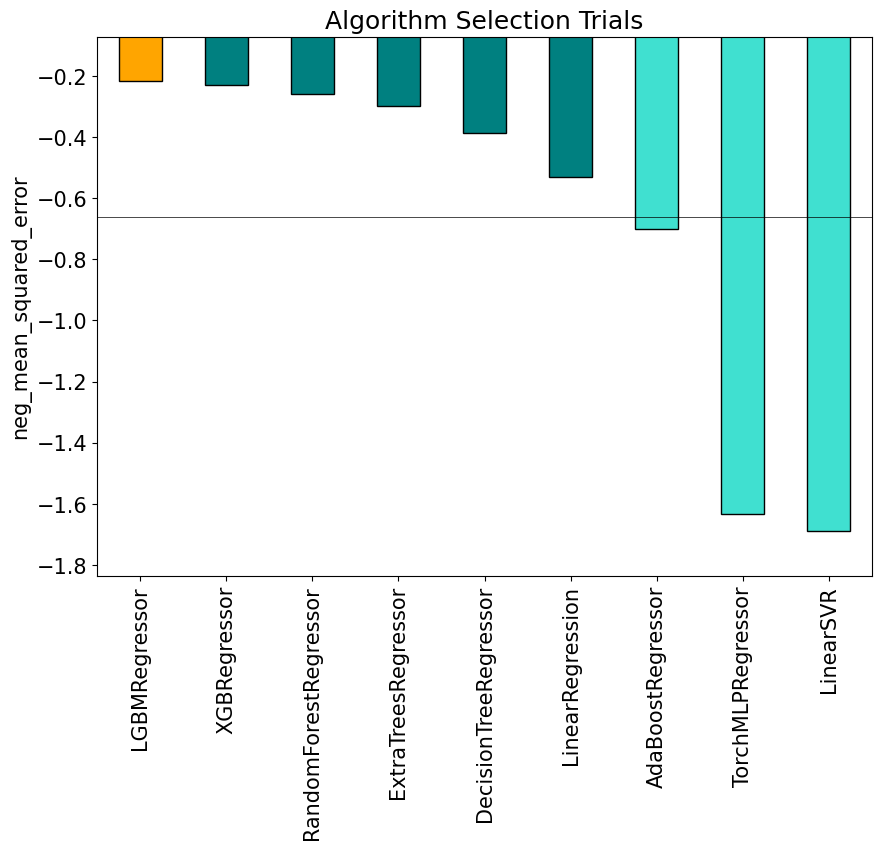

In [11]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Model Selection')]
name_of_score_column = f"Score ({est1._inferred_score_metric[0].name})"
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
scores = trials[name_of_score_column].tolist()
models = trials['Algorithm'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)

colors = []
for f in s.keys():
    if f.strip() == est1.selected_model_.strip():
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est1._inferred_score_metric[0].name)
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

<a id='adaptive-sampling'></a>
#### Adaptive Sampling

Following Algorithm Selection, Adaptive Sampling aims to find the smallest dataset sample that can be created without compromising validation set score for the chosen model. This is used to speed up feature selection and tuning; however, the full dataset is still used to train the final model.

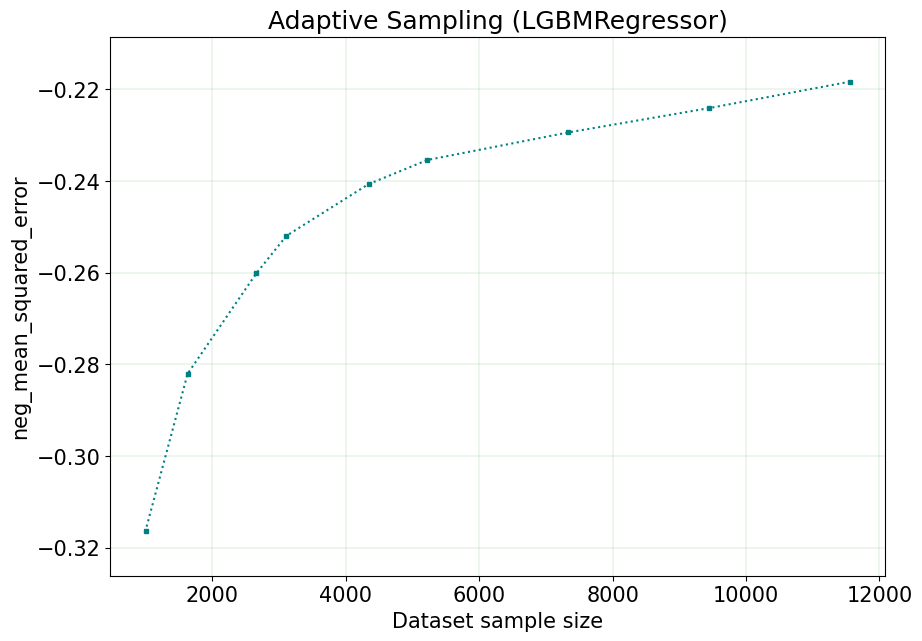

In [12]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Adaptive Sampling')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
scores = trials[name_of_score_column].tolist()
n_samples = trials['# Samples'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
fig, ax = plt.subplots(1)
ax.set_title("Adaptive Sampling ({})".format(est1.selected_model_))
ax.set_xlabel('Dataset sample size')
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_samples, scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

<a id='feature-selection'></a>
#### Feature Selection

The next step of the pipeline is to find a relevant feature subset to maximize score for the chosen algorithm. AutoMLx Feature Selection follows an intelligent search strategy, looking at various possible feature rankings and subsets, and identifying that smallest feature subset that does not compromise on score for the chosen algorithm. The orange line shows the optimal number of features chosen by Feature Selection.

Features selected: ['AveOccup', 'AveRooms', 'HouseAge', 'Latitude', 'Longitude', 'MedInc']
Features dropped: ['AveBedrms', 'Population', 'Median Price']


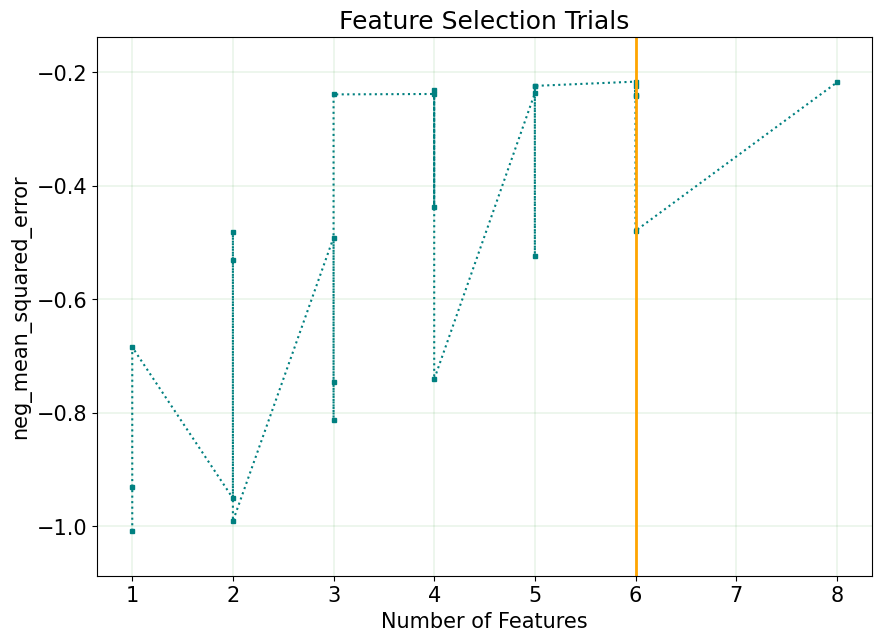

In [13]:
print(f"Features selected: {est1.selected_features_names_}")
dropped_features = df.drop(est1.selected_features_names_raw_, axis=1).columns
print(f"Features dropped: {dropped_features.to_list()}")

# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Feature Selection')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
trials.sort_values(by=['# Features'],ascending=True, inplace = True)
scores = trials[name_of_score_column].tolist()
n_features = trials['# Features'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
fig, ax = plt.subplots(1)
ax.set_title("Feature Selection Trials")
ax.set_xlabel("Number of Features")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
ax.axvline(x=len(est1.selected_features_names_), color='orange', linewidth=2.0)
plt.show()

<a id='hyperparameter-tuning'></a>
#### Hyperparameter Tuning

Hyperparameter Tuning is the last stage of the AutoMLx pipeline, and focuses on improving the chosen algorithm's score on the reduced dataset (after Adaptive Sampling and Feature Selection). We use a novel iterative algorithm to search across many hyperparameter dimensions, and converge automatically when optimal hyperparameters are identified. Each trial represents a particular hyperparameter configuration for the selected model.

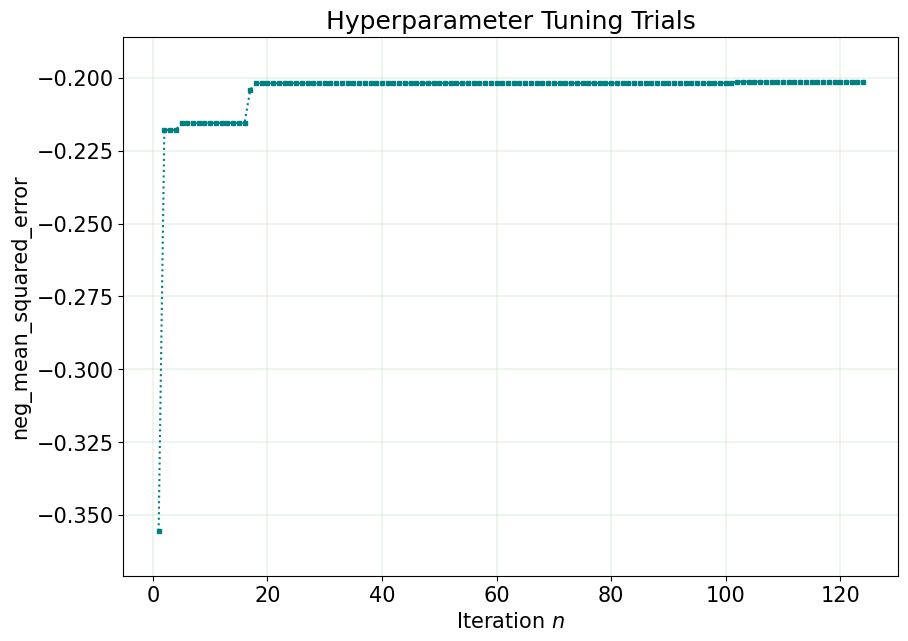

In [14]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Model Tuning')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
trials.drop(trials[trials['Finished'] == -1].index, inplace = True)
trials['Finished']= trials['Finished'].apply(lambda x: time.mktime(datetime.datetime.strptime(x,
                                             "%a %b %d %H:%M:%S %Y").timetuple()))
trials.sort_values(by=['Finished'],ascending=True, inplace = True)
scores = trials[name_of_score_column].tolist()
score = []
score.append(scores[0])
for i in range(1,len(scores)):
    if scores[i]>= score[i-1]:
        score.append(scores[i])
    else:
        score.append(score[i-1])
y_margin = 0.10 * (max(score) - min(score))
fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
ax.plot(range(1, len(trials) + 1), score, 'k:', marker="s", color='teal', markersize=3)
plt.show()

<a id='modellist'></a>
### Advanced AutoMLx Configuration

You can also configure the pipeline with suitable parameters according to your needs.

In [15]:
custom_pipeline = automlx.Pipeline(
    task='regression',           
    model_list=[                 # Specify the models you want the AutoMLx to consider
        'LinearRegression',
        'AdaBoostRegressor',
        'XGBRegressor'
    ],
    n_algos_tuned=2,             # Choose how many models to tune
    min_features=1.0,            # Specify minimum features to force the model to use. It can take 3 possible types of values:
                                 # If int, 0 < min_features <= n_features,
                                 # If float, 0 < min_features <= 1.0, 1.0 means disabling feature selection
                                 # If list, names of features to keep, for example ['a', 'b'] means keep features 'a' and 'b'

    adaptive_sampling=False,     # Disable or enable Adaptive Sampling step. Default to `True`
    preprocessing=True,          # Disable or enable Preprocessing step. Default to `True`
    search_space={               # You can specify the hyper-parameters and ranges we search
        'AdaBoostRegressor': {
            "n_estimators": {"range": [10, 20], "type": "discrete"}
        },
    },
    max_tuning_trials=2,         # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
    score_metric='r2',           # Any scikit-learn metric or a custom function
)

<a id='custom-validation'></a>
### Use a custom validation set
You can specify a custom validation set that you want AutoMLx to use to evaluate the quality of models and configurations.


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=0)

A few of the advanced settings can be passed directly to the pipeline's fit method, instead of its constructor.

In [17]:
custom_pipeline.fit(
    X_train,
    y_train,
    X_val,
    y_val,
    time_budget= 20,    # Specify time budget in seconds
    cv='auto'           # Automatically pick a good cross-validation (cv) strategy for the user's dataset.
                        # Ignored if X_valid and y_valid are provided.
                        # Can also be:
                        #   - An integer (For example, to use 5-fold cross validation)
                        #   - A list of data indices to use as splits (for advanced, such as time-based splitting)
)
y_pred = custom_pipeline.predict(X_test)
score_modellist = mean_squared_error(y_test, y_pred)

print(f'Prediction error (MSE) on test data : {score_modellist}')

[2024-08-15 19:33:53,420] [automlx.interface] Dataset shape: (14448,8)


[2024-08-15 19:33:53,551] [automlx.interface] Adaptive Sampling disabled.


[2024-08-15 19:33:53,812] [automlx.data_transform] Running preprocessing. Number of features: 9


[2024-08-15 19:33:54,126] [automlx.data_transform] Preprocessing completed. Took 0.313 secs


[2024-08-15 19:33:54,207] [automlx.process] Running Model Generation


[2024-08-15 19:33:54,356] [automlx.process] Model Generation completed.


[2024-08-15 19:33:54,537] [automlx.model_selection] Running Model Selection


[2024-08-15 19:33:56,422] [automlx.model_selection] Model Selection completed - Took 1.885 sec - Selected models: ['XGBRegressor', 'LinearRegression']


[2024-08-15 19:33:56,833] [automlx.trials] Running Model Tuning for ['TargetInputTransformer_XGBRegressor']


[2024-08-15 19:33:58,972] [automlx.trials] Best parameters for TargetInputTransformer_XGBRegressor: {'n_estimators': 100, 'min_child_weight': 1, 'reg_alpha': 0, 'booster': 'dart', 'max_depth': 6, 'learning_rate': 0.1, 'reg_lambda': 1}


[2024-08-15 19:33:58,973] [automlx.trials] Model Tuning completed. Took: 2.140 secs


[2024-08-15 19:33:59,489] [automlx.trials] skipping model tuning for pipelines: ['TargetInputTransformer_LinearRegression']


[2024-08-15 19:33:59,961] [automlx.interface] Re-fitting pipeline


[2024-08-15 19:34:02,663] [automlx.interface] AutoMLx completed.


Prediction error (MSE) on test data : 0.23716484748805952


<a id='MLX'></a>
## Machine Learning Explainability

For a variety of decision-making tasks, getting only a prediction as model output is not sufficient. A user may wish to know why the model outputs that prediction, or which data features are relevant for that prediction. For that purpose the Oracle AutoMLx solution defines the `MLExplainer` object, which allows to compute multiple types of model explanations.

<a id='MLX-initializing'></a>
### Initialize an MLExplainer

The `MLExplainer` object takes as argument the trained model, the training data and labels, as well as the task.

In [18]:
explainer = automlx.MLExplainer(est1,
                              X_train,
                              y_train,
                              task="regression")

<a id='global'></a>
### Model Explanations (Global Feature importance)

The notion of Global Feature Importance intuitively measures how much the model's performance (relative to the provided train labels) would change if a given feature were dropped from the dataset, <b><i>without</i></b> allowing the model to be retrained. This notion of feature importance considers each feature independently from all other features.

#### Compute the importance

By default we use a permutation method to successively measure the importance of each feature. Such a method therefore runs in linear time with respect to the
number of features in the dataset.

The method `explain_model()` allows to compute such feature importances. It also provides 95% confidence intervals for each feature importance.

In [19]:
result_explain_model_default = explainer.explain_model(
    n_iter=5,                            # Can also be 'auto' to pick a good value for the explainer and task

    scoring_metric='r2',  # Global feature importance measures how much each feature improved the
                                         # model's score. Users can chose the scoring metric used here.
)

#### Visualization

There are two options to show the explanation's results:
- `to_dataframe()` will return a dataframe of the results.
- `show_in_notebook()` will show the results as a bar plot.

The features are returned in decreasing order of importance. We see that `Latitude` and `Longitude` are considered to be the most important features.

In [20]:
result_explain_model_default.to_dataframe()

feature  attribution  upper_bound  lower_bound
0   Latitude     1.019030     1.037167     1.000892
1  Longitude     0.875600     0.911919     0.839281
2     MedInc     0.423944     0.435990     0.411898
3   AveOccup     0.150725     0.160388     0.141062
4   AveRooms     0.102972     0.110413     0.095531
5   HouseAge     0.061815     0.066679     0.056951

In [21]:
result_explain_model_default.show_in_notebook()

<a id='MLX-dependency'></a>
### Feature Dependence Explanations (PDP + ICE)

Another way to measure dependency on a feature is through a partial dependence plot (PDP) or an individual conditional expectation (ICE) plot. For accumulated local effects (ALE) explanations, see <a href='#MLX-advanced-ale'>Advanced Feature Dependence Options (ALE)</a>

Given a dataset, a PDP displays the average output of the model as a function of the value of the selected set of features (Up to 4 features).

It can be computed for a single feature, as in the cell below. The X-axis is the value of the `Latitude` feature and the y-axis is the corresponding outputted price. Since we are considering the whole dataset, the average over outputs is given by the red line, while the shaded interval corresponds to a 95% confidence interval for the average.

The histogram on top shows the distribution of the value of the `Latitude` feature in the dataset.

In [22]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence('Latitude')
result_explain_feature_dependence_default.show_in_notebook()

The ICE plot is automatically computed at the same time as any one-feature PDP. It can be accessed by passing `ice=True` to `show_in_notebook`.

Similar to PDPs, ICE plots show the median prediction as a model red line. However, the variance in the model's predictions are shown by plotting the predictions of a sample of individual data instances as light grey lines. (For categorical features, the distribution in the predictions is instead shown as a violin plot.)

In [23]:
result_explain_feature_dependence_default.show_in_notebook(ice=True)

We can also plot the PDP for multiple features. The plot below is the PDP for the `Latitude` and `Longitude` features. The X-axis still shows the values of `Latitude`, while there is a different curve and confidence interval for each value of the feature `Longitude`.

The histogram displays the joint distribution of the two features.

In [24]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence(['Latitude', 'Longitude'])
result_explain_feature_dependence_default.show_in_notebook()

<a id='MLX-local'></a>
###  Prediction Explanations (Local Feature Importance)

Given a data sample, one can also obtain the local importance, which is the importance of the features for the model's prediction on that sample.
In the following cell, we consider sample $10$. The function `explain_prediction()` computes the local importance for a given sample.

`Latitude=33.0` means that the value of feature `Latitude` for that sample is `33.0`. Removing that feature would change the model's prediction by the magnitude of the bar. That is, in this case, the model's prediction for the median house price is approximately 1.15 (i.e., $115 000) less because the model knows the value of `Latitude` is `33.0`.

In [25]:
result_explain_prediction_default = explainer.explain_prediction(X_train.sample(n=10))
result_explain_prediction_default[0].show_in_notebook()

<a id='MLX-alfi'></a>
### Aggregate Local Feature Importance
We now summarize all of the individual local feature importance explanations into one single aggregate explanation.

In [26]:
alfi = explainer.aggregate(explanations=result_explain_prediction_default)
alfi.show_in_notebook()

<a id='MLX-whatif'></a>
## Interactive What-If Explanations

The Oracle AutoMLx solution offers also What-IF tool to explain a trained ML model's predictions through a simple interactive interface.

You can use What-IF explainer to explore and visualize immediately how changing a sample value will affect the model's prediction. Furthermore, What-IF can be used to visualize how model's predictions are related to any feature of the dataset.

In [27]:
explainer.explore_whatif(X_test, y_test)

<a id='Counterfactuals'></a>
## Counterfactual Explanations

Counterfactual explainers are another set of advanced features that Oracle AutoMLx supports, which help to explain a trained ML model's predictions by identifying the minimal set of changes necessary to flip the model's decision, resulting in a different outcome. To achieve this, the solution frames the explanation process as an optimization problem, similar to adversarial discoveries, while ensuring that the counterfactual perturbations used are feasible and diverse.

With the Oracle AutoMLx solution, users are guaranteed a close to zero-failure rate in generating a set of counterfactual explanations; the explainers might only fail if the reference training set doesn't contain any example with the desired class.
AutoMLx also provides support for simple constraints on features, using `features_to_fix` and `permitted_range`, to ensure the feasibility of the generated counterfactual examples. Additionally, users can use tunable parameters to control the proximity and diversity of the explanations to the original input.

Currently, the Oracle AutoMLx solution supports `dice_random` for creating counterfactual examples for regression models. This is a tool for creating diverse counterfactual explanations introduced by Microsoft (https://github.com/interpretml/DiCE).

The final results can be returned either through the interactive interface of `What-IF` tools to show the model's prediction sensitivity or static tables and figures.

In [28]:
explainer.configure_explain_counterfactual(strategy='dice_random')
explanations = explainer.explain_counterfactual(X_test.iloc[0, :],
                                               n_counterfactuals=3,
                                               desired_pred=(3.5, 5))
explanations[0].show_in_notebook()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

<a id='MLX-advanced'></a>
### Advanced Feature Importance Options

We now display more advanced configuration for computing feature importance. Here, we will explain a custom `LinearRegression` estimator from `scikit-learn`. Note that the `MLExplainer` object is capable of explaining any regression model, as long as the model follows a scikit-learn-style interface with the `predict` function.

In [29]:
scikit_model = LinearRegression()
scikit_model.fit(X_train, y_train)

explainer_sklearn = automlx.MLExplainer(
                              scikit_model,
                              X_train,
                              y_train,
                              target_names=[             # Used for plot labels/legends.
                                  'Median Price'
                              ],
                              selected_features='auto',  # These features are used by the model; automatically inferred for AutoML Pipelines,
                              task="regression",         
                              col_types=None             # Specify type of features
                             )

<a id='MLX-including'></a>
### Configure prediction explanation

#### Include the effects of feature interactions (with Shapley feature importance)

The Oracle AutoMLx solution allows one to change the effect of feature interactions. This can be done through the `tabulator_type` argument of both global and local importance methods.

`tabulator_type` can be set to one of the following options:

- `permutation`: This value is the default method in the MLExplainer object, with the behaviour described above

- `shapley`: Feature importance is computed using the popular game-theoretic Shapley value method. Technically, this measures the importance of each feature while including the effect of all feature interactions. As a result, it runs in exponential time with respect to the number of features in the dataset. This method also includes the interaction effects of the other features, which means that if two features contain duplicate information, they will be less important. Note that the interpretation of this method's result is a bit different from the permutation method's result. An interested reader may find <a href='https://christophm.github.io/interpretable-ml-book/shapley.html'>this</a> a good source for learning more about it.

- `kernel_shap`: Feature importance attributions will be calculated using an approximation of the Shapley value method. It typically provides relatively high-quality approximations; however, it currently does not provide confidence intervals.

- `shap_pi`: Feature importance attributions will be computed using an approximation of the Shapley value method. It runs in linear time, but may miss the effect of interactions between some features, which may therefore produce lower-quality results. Most likely, you will notice that this method yields larger confidence intervals than the other two.

**Summary: `permutation` can miss important features for AD. Exact SHAP (`shapley`) doesn't, but it is exponential. `kernel_shap` is an approximation of exact SHAP method that does not provide confidence intervals. `shap_pi` is linear, thus faster than exact SHAP and kernel_shap but unstable and very random leads to lower quality approximations.**

<a id='MLX-advance-tabulator-prediction'></a>
##### Local feature importance with kernel_shap

In [30]:
explainer_sklearn.configure_explain_prediction(tabulator_type="kernel_shap")

<a id='MLX-surrogates'></a>
#### Local feature importance using surrogate models (LIME+)

The Oracle AutoMLx solution allows one to change the type of local explainer effect of feature interactions. This can be done through the `explainer_type` argument of local importance methods.

`explainer_type` can be set to one of the following options:

- `perturbation`: This value is the default explainer type in local feature importance. As we showed above, the explanation(s) will be computed by perturbing the features of the indicated data instance(s) and measuring the impact on the model predictions.

- `surrogate`: The LIME-style explanation(s) will be computed by fitting a surrogate model to the predictions of the original model in a small region around the indicated data instance(s) and measuring the importance of the features to the interpretable surrogate model. The method of surrogate explainer can be set to one of the following options:
  - `systematic`: An Oracle-labs-improved version of LIME that uses a systematic sampling and custom sample weighting. (Default)
  - `lime`: Local interpretable model-agnostic explanations (LIME) algorithm (https://arxiv.org/pdf/1602.04938).

In [31]:
explainer_sklearn.configure_explain_prediction(
                                               explainer_type='surrogate',
                                               method='lime'
                                              )

In [32]:
index = 0
result_explain_prediction_kernel_shap = explainer_sklearn.explain_prediction(X_train.iloc[index:index+1, :])
result_explain_prediction_kernel_shap[0].show_in_notebook()

<a id='MLX-explain'></a>
#### Explain the model or Explain the world

Oracle AutoMLx solution also provides the `evaluator_type` attribute, which allows one to choose whether to get feature importance attributions that explain exactly which features the model has learned to use (`interventional`), or which features the model or a retrained model could have learned to use (`observational`).

- `interventional` : The computed feature importances are as faithful to the
    model as possible. That is, features that are ignored by
    the model will not be considered important. This setting
    should be preferred if the primary goal is to learn about
    the machine learning model itself. Technically, this
    setting is called 'interventional', because the method will
    intervene on the data distribution when assessing the
    importance of features. The intuition of feature importance attributions computed with this method is that the features are dropped from the dataset and the model is not allowed to retrain.

- `observational` : The computed feature importances are more faithful to
    the relationships that exist in the real world (i.e., relationships
    observed in the dataset), even if your specific model did not learn
    to use them. For example, when using a permutation tabulator, a feature
    that is used by the model will not show a large impact on the model's
    performance if there is a second feature that contains near-duplicate
    information, because a re-trained model could have learned to use the
    other feature instead. (Similarly, for Shapley-based tabulators, a
    feature that is ignored by the model may have a non-zero feature
    importance if it could have been used by the model to
    predict the target.) This setting should be preferred if the
    model is merely a means to learn more about the
    relationships that exist within the data. Technically, this
    setting is called 'observational', because it observes the
    relationships in the data without breaking the existing
    data distribution.

<a id='MLX-advance-evaluator-model'></a>
##### Explain the model with observational evaluator_type

In [33]:
explainer_sklearn.configure_explain_model(evaluator_type="observational")

In [34]:
result_explain_model_kernel_shap = explainer_sklearn.explain_model()
result_explain_model_kernel_shap.show_in_notebook()

<a id='MLX-advance-evaluator-prediction'></a>
##### Explain predictions with observational evaluator_type

In [35]:
explainer_sklearn.configure_explain_prediction(evaluator_type="observational",
                                              tabulator_type="permutation")

[2024-08-15 19:34:44,263] [automlx.mlx] AutoMLx got an unexpected keyword argument 'evaluator_type', which is not a configurable attribute of any of ['TabularLocalSurrogateExplainer', 'RandomSampleGeneration', 'DistanceWeighting', 'SurrogateHandler'].
Valid options are:
{'TabularLocalSurrogateExplainer': ['method', 'exp_sorting', 'num_features', 'scale_weight'], 'RandomSampleGeneration': ['discretizer', 'num_samples', 'sample_around_instance'], 'DistanceWeighting': ['kernel_width', 'distance_metric', 'dataset_type'], 'SurrogateHandler': ['model', 'feature_selection', 'force_fit_sample']}


[2024-08-15 19:34:44,264] [automlx.mlx] AutoMLx got an unexpected keyword argument 'tabulator_type', which is not a configurable attribute of any of ['TabularLocalSurrogateExplainer', 'RandomSampleGeneration', 'DistanceWeighting', 'SurrogateHandler'].
Valid options are:
{'TabularLocalSurrogateExplainer': ['method', 'exp_sorting', 'num_features', 'scale_weight'], 'RandomSampleGeneration': ['discretizer', 'num_samples', 'sample_around_instance'], 'DistanceWeighting': ['kernel_width', 'distance_metric', 'dataset_type'], 'SurrogateHandler': ['model', 'feature_selection', 'force_fit_sample']}


In [36]:
index = 0
result_explain_prediction_kernel_shap = explainer_sklearn.explain_prediction(X_train.iloc[index:index+1, :])
result_explain_prediction_kernel_shap[0].show_in_notebook()

<a id='MLX-advanced-ale'></a>
### Advanced Feature Dependence Options (ALE)

We now show how to use an alternative method for computing feature dependence: accumulated local effects (ALE). ALE explanations are sometimes considered a better alternative to PDPs when features are correlated, because it does not evaluate the model outside of its training distribution in these cases. For more information, see https://christophm.github.io/interpretable-ml-book/ale.html.

Given a dataset, an ALE displays the average change in the output of the model, accumulated over multiple small changes in one or two features, when all other features are held fixed. By default, the ALE explanations are centered around 0, and thus, unlike PDPs, ALEs show the change in the prediction measured by changing a given feature, rather than the average model's prediction for a particular feature value.

We can  compute ALEs for two features (At least one is numerical). The plot below is the ALE plot for the `Latitude` and `Longitude` features. The X-axis still shows the values of `Latitude`, while there is multiple lines, one for each value of the feature `Longitude`.

The histogram displays the joint distribution of the two features.

In [37]:
explainer_sklearn.configure_explain_feature_dependence(explanation_type='ale')
result_explain_feature_dependence_default = explainer_sklearn.explain_feature_dependence(['Latitude', 'Longitude'])
result_explain_feature_dependence_default.show_in_notebook()

<a id='ref'></a>
## References
* Oracle AutoML http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* scikit-learn https://scikit-learn.org/stable/
* Interpretable Machine Learning https://christophm.github.io/interpretable-ml-book/
* LIME https://arxiv.org/pdf/1602.04938